In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math, random
from graphviz import Digraph
import plotly.graph_objects as go

#### Visualization

In [2]:
def trace(root):
    # Topological sort
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad  %.4f} " % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

### Autograd Engine

In [3]:
class Value:
    """Object that keeps track of operation performed to
    to compute the gradient
    """

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._op = _op
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __rsub__(self, other):
        return -self + other

    def __repr__(self):
        if self.label:
            return f"Value(data={self.data}, label={self.label})"
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            # Addition always routes the gradient
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            # Multiplication takes the other input and the next
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data**other.data, _children=(self,), label="f**(other)")

        def _backward():
            # We know that, d(x^2)/dx = 2 * x ** (2 - 1) * dx / dx
            self.grad = other * (self ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(data=t, _children=(self,), _op="tanh")

        def _backward():
            # The derivative of tanh is a form of tanh
            # So it is very efficient for computation
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def sigmoid(self):
        n = self.data
        sig = 1 / (1 + math.exp(-n))
        out = Value(data=sig, _children=(self,), _op="sigmoid")

        def _backward():
            # The derivative of sigmoid is sigmoid function itself
            # d(sigmoid)/dx = sigmoid * (1 - sigmoid)
            self.grad += sig * (1 - sig) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        # Contains the output of the exponential op
        out = Value(math.exp(self.data), _children=(self,), _op="exp")

        def _backward():
            # d(e**x)/dx = e**x
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def log(self):
        n = self.data
        log_value = math.log2(n)

        out = Value(data=log_value, _children=(self,), _op="log")

        def _backward():
            # d(log_2(x))/dx = 1 / (x * ln(2))
            self.grad += (1 / (n * math.log(2))) * out.grad

        out._backward = _backward

        return out

    def __neg__(self):
        return -1 * self

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        # We can by pass implementing for diff directly
        return self.data * (other.data**-1)

    def backward(self):
        # Topological sort
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        # On the last node, we cann the backward function!
        # So, we need to have the dL/dL defined, will work
        # as a base case
        self.grad = 1.00

        # compute the gradients
        for node in reversed(topo):
            node._backward()

### Derivative visualization [tanh and sigmoid]

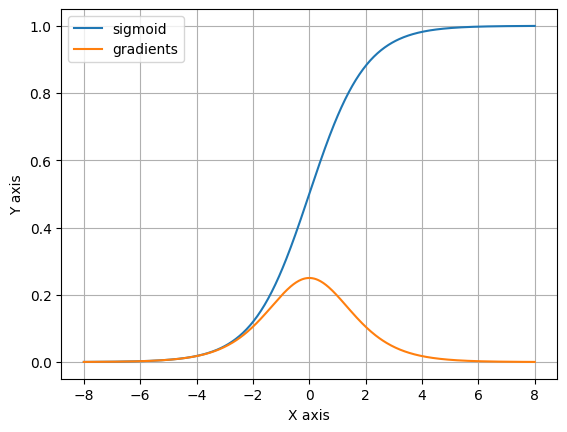

In [4]:
# X axis values
x_values = [Value(ix) for ix in np.linspace(-8, 8, 500)]
x_data = [ix.data for ix in x_values]

# Compute Sigmoid
sigmoid_values = [ix.sigmoid() for ix in x_values]
sigmoid_data = [ix.data for ix in sigmoid_values]

# Plot the graph
plt.plot(x_data, sigmoid_data, label="sigmoid")

# Compute gradients
for node in sigmoid_values:
    node.backward()

# So it you compute sigmoid(), the value on which you compute
# sigmoid on, derivative of it is small hence we end up having
# vanishing gradient issue
sigmoid_grads = [sig.grad for sig in x_values]
plt.plot(x_data, sigmoid_grads, label="gradients")

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.grid(True)
plt.show()

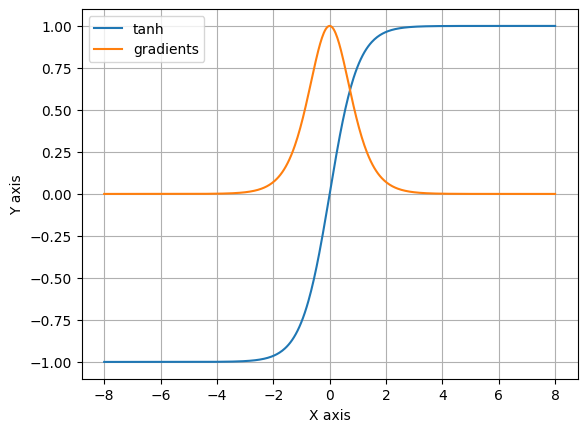

In [5]:
# X axis values
x_values = [Value(ix) for ix in np.linspace(-8, 8, 500)]
x_data = [ix.data for ix in x_values]

# Compute tanh
tanh_values = [ix.tanh() for ix in x_values]
tanh_data = [ix.data for ix in tanh_values]

# Plot the graph
plt.plot(x_data, tanh_data, label="tanh")

# Compute gradients
for node in tanh_values:
    node.backward()

# So it you compute tanh(), the value on which you compute
# tanh on, derivative of it is small hence we end up having
# vanishing gradient issue
tanh_grads = [sig.grad for sig in x_values]
plt.plot(x_data, tanh_grads, label="gradients")

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.grid(True)
plt.show()

### Computational graph

In [6]:
# Input data
x1 = Value(0.23, label="x1")
x2 = Value(5.0, label="x2")

# Weights
w1 = Value(-1.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(0.001, label="b")

# Comute intermideate nodes
x1w1 = x1 * w1
x1w1.label = "x1 * w1"

x2w2 = x2 * w2
x2w2.label = "x2 * w2"

# Compute the dot product
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1 * w1 + x2 * w2"

neuron = x1w1x2w2 + b
neuron.label = "neuron"

# Apply the activation function
out = neuron.sigmoid()
out.label = "output"

out.backward()

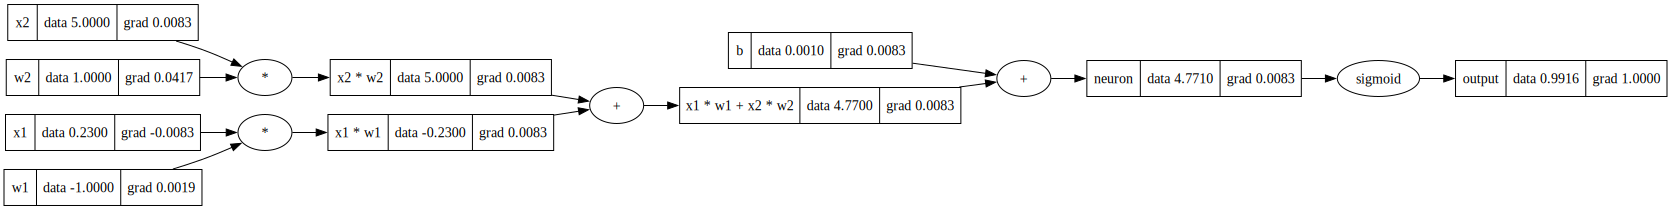

In [7]:
draw_dot(out)

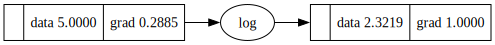

In [8]:
# Simple graph
a = Value(5.0)
out = a.log()

out.backward()

draw_dot(out)

### Define a Neuron

In [9]:
class Neuron:
    def __init__(self, n_in):
        self.n_in = n_in
        self.weights = [
            Value(random.uniform(-1, 1), label=f"w_{i}")
            for i, _ in enumerate(range(self.n_in), start=1)
        ]
        self.bias = Value(random.uniform(-1, 1), label="b")

    def __call__(self, x):
        assert self.n_in == len(x), "Input size does not match"
        # Compute wT.x + b
        act = sum([ix * iw for ix, iw in zip(self.weights, x)], self.bias)
        # Pass it through an activation func to squeeze the output
        out = act.tanh()
        return out

    def parameters(self):
        return self.weights + [self.bias]
    
    
    def __repr__(self):
        return f'Neuron(n_in={self.n_in})'

### Perceptron

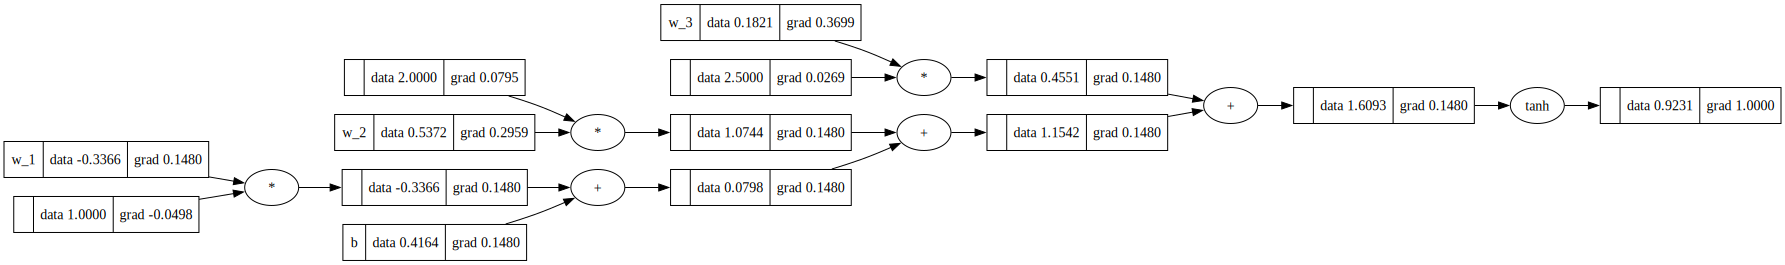

In [10]:
x = [1.0, 2.0, 2.5]

neuron = Neuron(n_in=len(x))
out = neuron(x)
out.sigmoid()

# Compute grad
out.backward()

draw_dot(out)

### Define a Layer

In [11]:
class Layer:
    def __init__(self, n_in, num_neurons):
        self._n_in = n_in
        self._num_neurons = num_neurons

        self.neurons = [Neuron(n_in) for num_neuron in range(num_neurons)]

    def __call__(self, x):
        layer_out = [neu(x) for neu in self.neurons]
        return layer_out[0] if len(layer_out) == 1 else layer_out

    def parameters(self):
        params = []
        for neu in self.neurons:
            p = neu.parameters()
            params.append(p)
        return params

    def __repr__(self):
        return f"Layer(n_in={self._n_in}, num_neurons={self._num_neurons})"

### Define a MLP

In [12]:
class MLP:
    def __init__(self, n_in, num_neurons_in_layer):
        mlp_info = [n_in] + num_neurons_in_layer
        # Perform a sliding window
        self.layers = [
            Layer(mlp_info[i], mlp_info[i + 1]) for i in range(len(mlp_info) - 1)
        ]

    def __call__(self, x):
        # Perform a forward pass through all the layers
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Layers
[Layer(n_in=3, num_neurons=4), Layer(n_in=4, num_neurons=4), Layer(n_in=4, num_neurons=1)]

Neurons
[Neuron(n_in=3), Neuron(n_in=3), Neuron(n_in=3), Neuron(n_in=3)]
[Neuron(n_in=4), Neuron(n_in=4), Neuron(n_in=4), Neuron(n_in=4)]
[Neuron(n_in=4)]



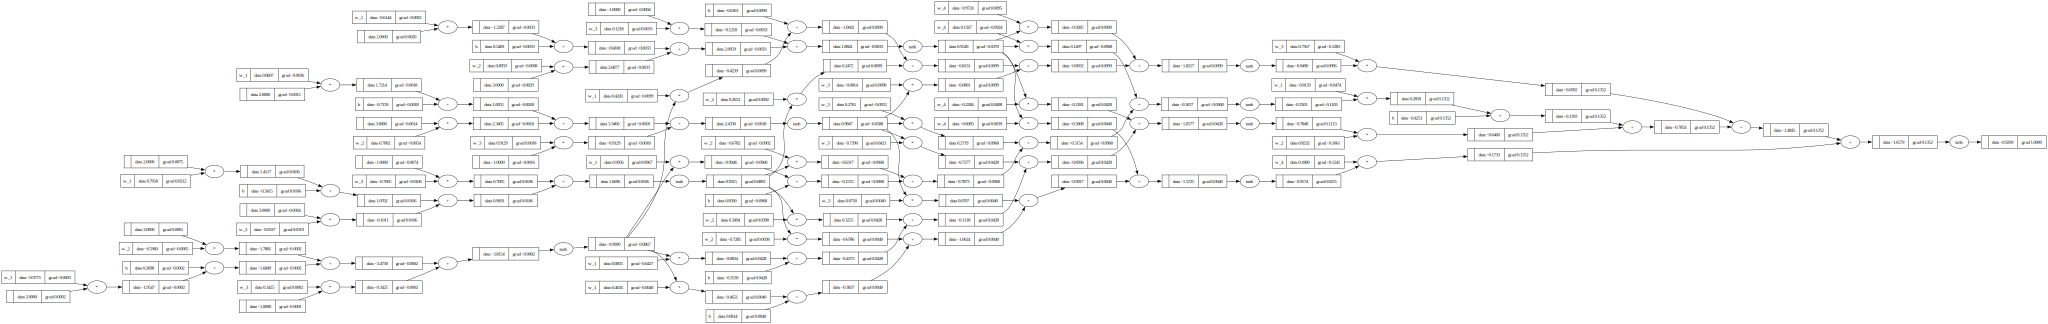

In [13]:
x = [2.0, 3.0, -1.0]
model = MLP(3, [4, 4, 1])

print("Layers")
print(model.layers)

print()


print("Neurons")
for layer in model.layers:
    print(layer.neurons)

print()

out = model(x)
out.backward()

draw_dot(out)

### Backpropagation in Action! Yay

In [14]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [15]:
for _ in range(100):

    # forward pass
    ypred = [model(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))


    # set the gradients zero
    for params in model.parameters():
        for param in params:
            param.grad = 0.0

    # Compute the gradients
    loss.backward()

    # Backward pass
    for params in model.parameters():
        for param in params:
            # TODO: Why is it becoming Value(data=Value(...))?
            # Weird bug
            param.data += -0.01 * param.grad.data
            
    print(_ + 1, loss.data)

1 7.3396428153851705
2 7.156760957315953
3 6.92038068697445
4 6.603941172267595
5 6.17928269386524
6 5.636352751858181
7 5.0158226509362045
8 4.40311754801216
9 3.8571462640805168
10 3.3803029730666285
11 2.956397584469913
12 2.576664414988387
13 2.2401258613512156
14 1.9463870563823211
15 1.6913501738669314
16 1.4682259836948273
17 1.2706153192855643
18 1.0943041146719767
19 0.9372506792391335
20 0.798707266630116
21 0.6782885768199481
22 0.5753436826171779
23 0.4886977966705254
24 0.4166883559187429
25 0.35736260833331046
26 0.30870861966304813
27 0.2688373917247088
28 0.2360880056698308
29 0.20906481870985796
30 0.18662990022189477
31 0.16787275764435078
32 0.15207256540135863
33 0.1386613472343326
34 0.12719184038182096
35 0.11731106463471266
36 0.10873931014134156
37 0.10125375458191108
38 0.09467582265122139
39 0.08886147854493999
40 0.08369377745080078
41 0.07907714092900263
42 0.07493294253355695
43 0.07119608866687656
44 0.06781235664577907
45 0.06473631071426077
46 0.06192966